## Scope of this file
- an example of node classification using GCN

## basic concepts in Graph Neural Network (GNN) and its representation in PyG
[PyG Documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)

## Dataset description
This is the well-known and much-used Zachary karate club network. The data was collected from the members of a university karate club by Wayne Zachary in 1977. Each node represents a member of the club, and each edge represents a tie between two members of the club. The network is undirected. An often discussed problem using this dataset is to find the two groups of people into which the karate club split after an argument between two teachers. [more](https://blog.csdn.net/PolarisRisingWar/article/details/117532292)

## Load Data

In [2]:
from torch_geometric.datasets import karate

dataset = karate.KarateClub()

graph = dataset[0]

## Data exploration

In [13]:
print('Num of nodes:', graph.num_nodes)
print('Num of node features:', graph.num_node_features)
print('Node labels:', graph.y)
print('Num of edges:', graph.num_edges)
print('Num of edge features:', graph.num_edge_features)
print('Num of node features:\n', graph.x)

Num of nodes: 34
Num of node features: 34
Node labels: tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
Num of edges: 156
Num of edge features: 0
Num of node features:
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


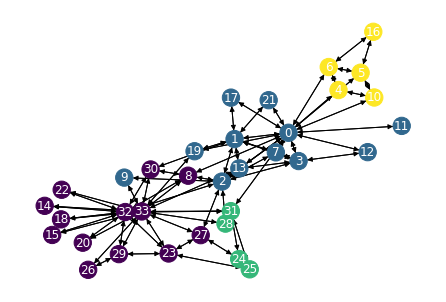

In [4]:
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from matplotlib import pyplot as plt

def show_graph(_graph, labels=None):
    if labels is None:
        labels = _graph.y
    _graph_nx = to_networkx(_graph)
    nx.draw(_graph_nx, with_labels=True, node_color=labels, font_color='white')
    plt.show()


show_graph(graph)

## Build GNN based on GCN
About GCN: [https://tkipf.com/graph-convolutional-networks/](https://tkipf.com/graph-convolutional-networks/)

In [15]:
import torch
from torch_geometric.nn.conv import GCNConv
from torch.functional import F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels=in_channels, out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=out_channels)

    def extract(self, _graph):
        x, edge_index = _graph.x, graph.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def forward(self, _graph):
        x = self.extract(_graph)
        return F.log_softmax(x, dim=1)

## An interesting point

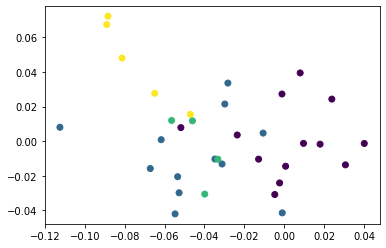

In [11]:
def show_out(_out, labels):
    plt.scatter(_out[:, 0].tolist(), _out[:, 1].tolist(), c=labels)
    plt.show()

model = GCN(graph.num_node_features, 2)
out = model.extract(graph)
show_out(out, graph.y.tolist())

## Train model

In [18]:
import random

model = GCN(graph.num_node_features, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_mask = [True if i < graph.num_nodes * 0.6 else False for i in range(graph.num_nodes)]
random.shuffle(train_mask)
test_mask = [False if x else True for x in train_mask]

model.train()
loss_lst = []
for epoch in range(200):
    print(epoch)
    optimizer.zero_grad()
    out = model(graph)
    loss = F.nll_loss(out[train_mask], graph.y[train_mask])
    print(loss)
    loss_lst.append(loss.item())
    loss.backward()
    optimizer.step()

0
tensor(1.4019, grad_fn=<NllLossBackward0>)
1
tensor(1.3728, grad_fn=<NllLossBackward0>)
2
tensor(1.3454, grad_fn=<NllLossBackward0>)
3
tensor(1.3179, grad_fn=<NllLossBackward0>)
4
tensor(1.2907, grad_fn=<NllLossBackward0>)
5
tensor(1.2634, grad_fn=<NllLossBackward0>)
6
tensor(1.2363, grad_fn=<NllLossBackward0>)
7
tensor(1.2094, grad_fn=<NllLossBackward0>)
8
tensor(1.1824, grad_fn=<NllLossBackward0>)
9
tensor(1.1554, grad_fn=<NllLossBackward0>)
10
tensor(1.1281, grad_fn=<NllLossBackward0>)
11
tensor(1.1008, grad_fn=<NllLossBackward0>)
12
tensor(1.0734, grad_fn=<NllLossBackward0>)
13
tensor(1.0460, grad_fn=<NllLossBackward0>)
14
tensor(1.0187, grad_fn=<NllLossBackward0>)
15
tensor(0.9916, grad_fn=<NllLossBackward0>)
16
tensor(0.9647, grad_fn=<NllLossBackward0>)
17
tensor(0.9378, grad_fn=<NllLossBackward0>)
18
tensor(0.9112, grad_fn=<NllLossBackward0>)
19
tensor(0.8848, grad_fn=<NllLossBackward0>)
20
tensor(0.8585, grad_fn=<NllLossBackward0>)
21
tensor(0.8324, grad_fn=<NllLossBackward0>

## Evaluate mode training

Accuracy: 92.31%


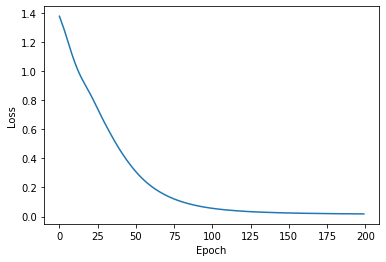

In [8]:
model.eval()
pred = model(graph).argmax(dim=1)
correct = (pred[test_mask] == graph.y[test_mask]).sum()
acc = int(correct) / int(sum(test_mask))
print(f'Accuracy: {acc:.2%}')

plt.plot(loss_lst)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()